# Autoencoder for image denoising

# IMPORTS

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image

NUM_CLASSES = 3
BATCH_SIZE = 128
EPOCHS = 10

# Load the dataset with images

# Animal faces dataset 

3 classes - cat, dog, wild

In [2]:
train_ds2_path = 'data/afhq/train'
test_ds2_path = 'data/afhq/val'

### Image example (label: cat)

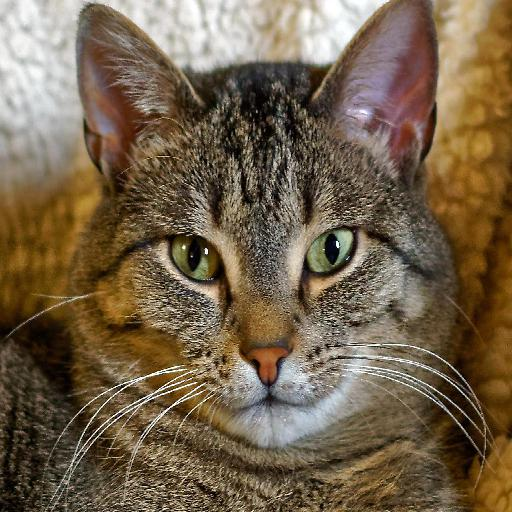

In [3]:
tf.keras.preprocessing.image.load_img(train_ds2_path + '/cat/flickr_cat_000014.jpg')

# Prepare data for training. Train and test sample generation

### Reduce the sample for faster training of neural networks during the study

In [4]:
def limit_data(data_dir,n=100):
    a=[]
    for i in os.listdir(data_dir):
        for k,j in enumerate(os.listdir(data_dir+'/'+i)):
            if k>n:continue
            a.append((f'{data_dir}/{i}/{j}',i))
    return pd.DataFrame(a,columns=['filename','class'])

In [5]:
train_df = limit_data('data/afhq/train', 2000)
train_df['class'].value_counts()

cat     2001
dog     2001
wild    2001
Name: class, dtype: int64

In [6]:
test_df = limit_data('data/afhq/val', 400)
test_df['class'].value_counts()

cat     401
dog     401
wild    401
Name: class, dtype: int64

In [7]:
training_generator = ImageDataGenerator(rescale=1./255, # multiply the data by the value provided (after applying all other transformations)
                                        rotation_range=3, # Int. Degree range for random rotations. 
                                        horizontal_flip=True, #  Boolean. Randomly flip inputs horizontally. 
                                        zoom_range=0.2) # Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]

training_dataset = training_generator.flow_from_dataframe(train_df,
                                                     target_size = (64, 64),
                                                     batch_size = 32,
                                                     class_mode = 'categorical',
                                                     shuffle = True)

Found 6003 validated image filenames belonging to 3 classes.


In [8]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_dataframe(test_df,
                                                     target_size = (64, 64),
                                                     batch_size = 1,
                                                     class_mode = 'categorical',
                                                     shuffle = True)

Found 1203 validated image filenames belonging to 3 classes.


### Since we only need images from the dataset to encode and decode, won't use the labels

In [9]:
train_data = np.concatenate([training_dataset.next()[0] for i in range(training_dataset.__len__())])
test_data = np.concatenate([test_dataset.next()[0] for i in range(test_dataset.__len__())])

train_labels = np.concatenate([training_dataset.next()[1] for i in range(training_dataset.__len__())])
test_labels = np.concatenate([test_dataset.next()[1] for i in range(test_dataset.__len__())])

print(train_data.shape)
print(test_data.shape)

(6003, 64, 64, 3)
(1203, 64, 64, 3)


### Create a copy of the data with added noise
### Display the train data and a version of it with added noise

In [10]:
def noise(array):
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(64, 64, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(64, 64, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

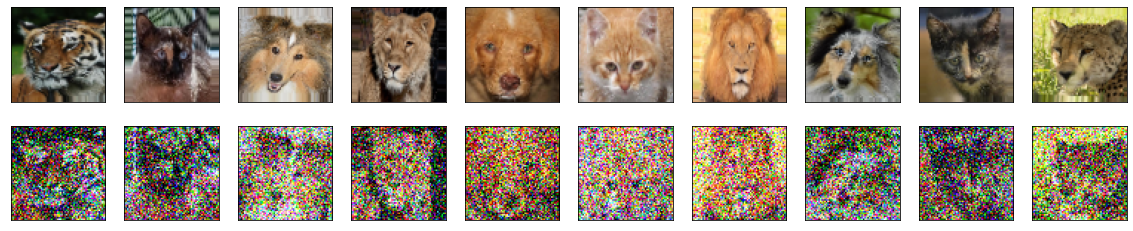

In [11]:
# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

# Build deep model for image denoising. Train it 

In [12]:
input = keras.layers.Input(shape = (64, 64, 3))

def encoder(input):
    conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = keras.layers.BatchNormalization()(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = keras.layers.BatchNormalization()(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = keras.layers.BatchNormalization()(conv4)
    conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = keras.layers.BatchNormalization()(conv4)

    return conv4

def decoder(conv4):    
    conv5 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv5 = keras.layers.BatchNormalization()(conv5)
    conv5 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = keras.layers.BatchNormalization()(conv5)
    conv6 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    conv6 = keras.layers.BatchNormalization()(conv6)
    conv6 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = keras.layers.BatchNormalization()(conv6)
    ups_1 = keras.layers.UpSampling2D((2,2))(conv6)
    conv7 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(ups_1)
    conv7 = keras.layers.BatchNormalization()(conv7)
    conv7 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = keras.layers.BatchNormalization()(conv7)
    ups_2 = keras.layers.UpSampling2D((2,2))(conv7)
    decoded = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(ups_2)

    return decoded

In [13]:
autoencoder = keras.Model(input, decoder(encoder(input)))
autoencoder.compile(loss = 'binary_crossentropy',
                    optimizer = keras.optimizers.Adam(learning_rate = 0.001))

In [14]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0     

# Randomly select several images from the test set, print them together with their reconstructions.

In [15]:
autoencoder.fit(x=noisy_train_data,
                y=train_data,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(noisy_test_data, test_data)
                )

Epoch 1/10
47/47 [==============================] - 75s 2s/step - loss: 0.6154 - val_loss: 1.0007
Epoch 2/10
47/47 [==============================] - 77s 2s/step - loss: 0.5853 - val_loss: 0.6956
Epoch 3/10
47/47 [==============================] - 78s 2s/step - loss: 0.5814 - val_loss: 0.6824
Epoch 4/10
47/47 [==============================] - 78s 2s/step - loss: 0.5794 - val_loss: 0.6575
Epoch 5/10
47/47 [==============================] - 79s 2s/step - loss: 0.5783 - val_loss: 0.6303
Epoch 6/10
47/47 [==============================] - 78s 2s/step - loss: 0.5774 - val_loss: 0.6300
Epoch 7/10
47/47 [==============================] - 79s 2s/step - loss: 0.5767 - val_loss: 0.6099
Epoch 8/10
47/47 [==============================] - 78s 2s/step - loss: 0.5764 - val_loss: 0.5859
Epoch 9/10
47/47 [==============================] - 78s 2s/step - loss: 0.5758 - val_loss: 0.5838
Epoch 10/10
47/47 [==============================] - 79s 2s/step - loss: 0.5756 - val_loss: 0.5867


38/38 [==============================] - 6s 155ms/step


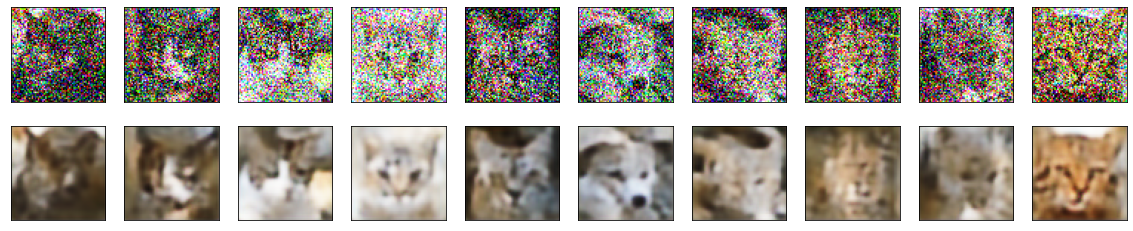

In [16]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

# Print the found low-level image features.

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 23ms/step


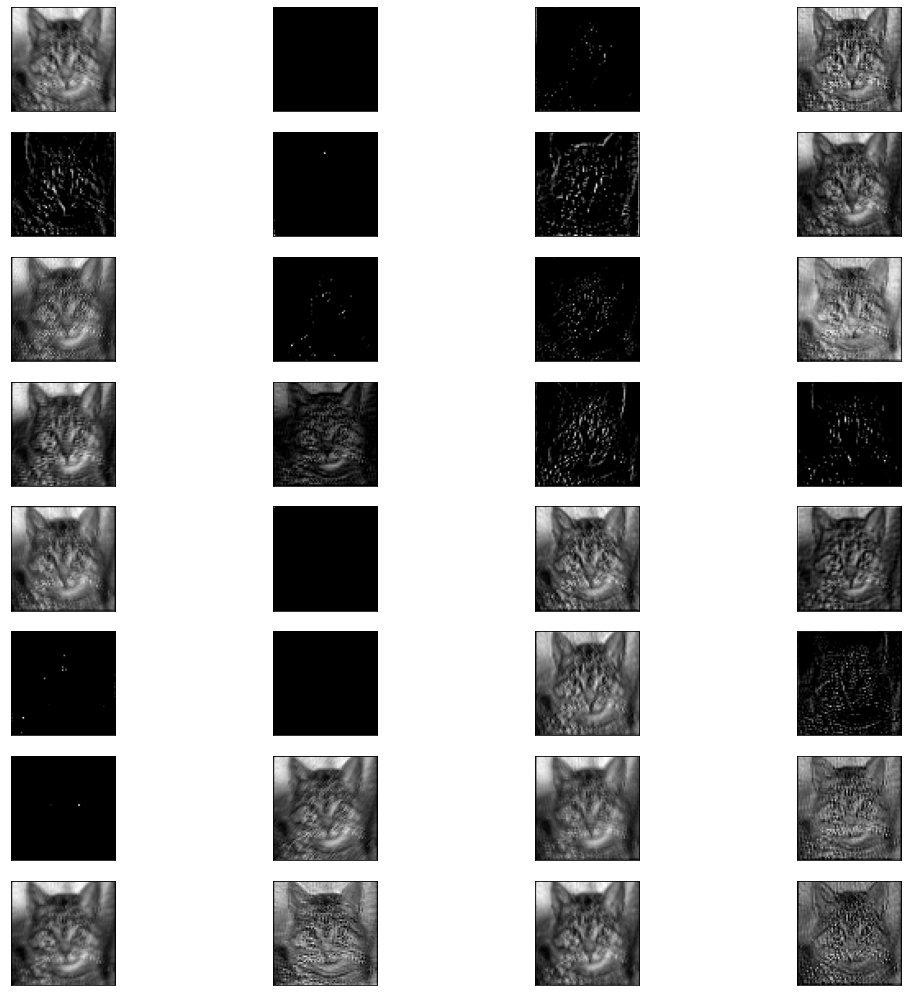

In [18]:
model = autoencoder
# redefine model to output right after the first hidden layer
model = keras.Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()
# load the image with the required shape
img = keras.preprocessing.image.load_img(train_ds2_path + '/cat/flickr_cat_000014.jpg', target_size=(64, 64, 3))
# convert the image to an array
img = keras.preprocessing.image.img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = (img/255)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 32 maps in an 4x4 squares
square = 4
ix = 1
fig, ax = plt.subplots(figsize=(18, 18))
for i in range(8):
	for j in range(4):
		# specify subplot and turn of axis
		ax = plt.subplot(8, 4, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
plt.show()

# Use the lowest layers of the built noise-reducing autoencoder model:

##  Based on them, build a deep neural network for classification.

In [56]:
def build_classification_model(autoencoder_model):
    enc = encoder(input)
    flatten = keras.layers.Flatten()(enc)
    dense   = keras.layers.Dense(128, activation='relu')(flatten)
    output  = keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense)
    
    model = keras.Model(input, output)
    
    # setting initial weights from autoencoder
    # layers[0:19] - encoder part of autoencoder
    for l1,l2 in zip(model.layers[:19], autoencoder.layers[0:19]):
        l1.set_weights(l2.get_weights())

    #forbid training layers taken from the autoencoder
    for layer in model.layers[0:19]:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])
    return model

In [57]:
classification_model = build_classification_model(autoencoder)
classification_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_79 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_78 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_80 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_79 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 32, 32, 32)       0   

## Train this model using 10% of the training set

In [60]:
print("Training data shape:",  train_data.shape)
print("Training labels shape:",  train_labels.shape)

print("Test data shape:",  test_data.shape)
print("Test labels shape:",  test_labels.shape)

Training data shape: (6003, 64, 64, 3)
Training labels shape: (6003, 3)
Test data shape: (1203, 64, 64, 3)
Test labels shape: (1203, 3)


In [69]:
classification_model = build_classification_model(autoencoder)
classification_model.fit(train_data[:601],
                        train_labels[:601],
                        batch_size=12,
                        epochs=10,
                        validation_split=0.2,
                        verbose=True)

Epoch 1/10
40/40 [==============================] - 3s 68ms/step - loss: 34.9771 - accuracy: 0.3438 - val_loss: 19.3645 - val_accuracy: 0.3719
Epoch 2/10
40/40 [==============================] - 3s 64ms/step - loss: 8.7522 - accuracy: 0.5521 - val_loss: 12.0324 - val_accuracy: 0.3967
Epoch 3/10
40/40 [==============================] - 3s 64ms/step - loss: 3.0955 - accuracy: 0.6687 - val_loss: 10.1462 - val_accuracy: 0.4050
Epoch 4/10
40/40 [==============================] - 3s 65ms/step - loss: 4.1325 - accuracy: 0.7542 - val_loss: 13.1501 - val_accuracy: 0.3967
Epoch 5/10
40/40 [==============================] - 3s 66ms/step - loss: 1.6990 - accuracy: 0.8042 - val_loss: 12.6238 - val_accuracy: 0.3306
Epoch 6/10
40/40 [==============================] - 3s 67ms/step - loss: 0.8915 - accuracy: 0.8521 - val_loss: 10.4365 - val_accuracy: 0.4132
Epoch 7/10
40/40 [==============================] - 3s 67ms/step - loss: 0.2326 - accuracy: 0.9083 - val_loss: 10.3146 - val_accuracy: 0.3802
Epoch

In [70]:
_, accuracy = classification_model.evaluate(test_data, test_labels, verbose = 0)

print(f'Test accuracy: {np.round(100 * accuracy, 3)}%')

Test accuracy: 35.827%


## Strong overfitting of the network is observed

## Can this model perform as well as a similar model trained on the full training set?

In [71]:
classification_model = build_classification_model(autoencoder)

classification_model.fit(train_data,
                        train_labels,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=(test_data, 
                                         test_labels),
                        verbose=True)

Epoch 1/10
47/47 [==============================] - 22s 469ms/step - loss: 6.0637 - accuracy: 0.3338 - val_loss: 1.2076 - val_accuracy: 0.3392
Epoch 2/10
47/47 [==============================] - 22s 479ms/step - loss: 1.1163 - accuracy: 0.3570 - val_loss: 1.1344 - val_accuracy: 0.3500
Epoch 3/10
47/47 [==============================] - 23s 493ms/step - loss: 1.0529 - accuracy: 0.3883 - val_loss: 1.1794 - val_accuracy: 0.3475
Epoch 4/10
47/47 [==============================] - 22s 478ms/step - loss: 1.0254 - accuracy: 0.4136 - val_loss: 1.1870 - val_accuracy: 0.3558
Epoch 5/10
47/47 [==============================] - 23s 492ms/step - loss: 0.9937 - accuracy: 0.4391 - val_loss: 1.2340 - val_accuracy: 0.3350
Epoch 6/10
47/47 [==============================] - 23s 498ms/step - loss: 0.9579 - accuracy: 0.4661 - val_loss: 1.2432 - val_accuracy: 0.3416
Epoch 7/10
47/47 [==============================] - 22s 479ms/step - loss: 0.9079 - accuracy: 0.4898 - val_loss: 1.3337 - val_accuracy: 0.3350

In [72]:
_, accuracy = classification_model.evaluate(test_data, test_labels, verbose = 0)

print(f'Test accuracy: {np.round(100 * accuracy, 3)}%')

Test accuracy: 33.915%


## Strong overfitting of the network is observed
## To prevent overtraining in this case, it is necessary to either reduce the depth of the encoder or add dropout layers to the encoder.